## PRML BONEAGE CLASSIFICATION

#### IMPORTS AND LOADING

In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND CONFIGURATION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, confusion_matrix, classification_report

# Progress bar
from tqdm import tqdm

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- PATHS BASED ON YOUR KAGGLE INPUTS ---
DATA_PATH = '/kaggle/input/rsna-bone-age'
# The deepest folder containing the actual image files
IMAGE_DIR = Path(f'{DATA_PATH}/boneage-training-dataset/boneage-training-dataset/') 
# Path to pre-trained ResNet weights from your specific input
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50-pretrained-wieghts/resnet50-11ad3fa6.pth'

# --- MODEL CONFIGURATION (5 CLASSES) ---
NUM_CLASSES = 5 
IMG_SIZE = 256
BATCH_SIZE = 32
MODEL_PATH = 'best_classifier_model_5class.pth'

Using device: cuda


#### We are doing 5 class classification
- Class 0: 0 <= Age < 48 months (0.0 - 4.0y)
- Class 1: 48 <= Age < 96 months (4.0 - 8.0y)
- Class 2: 96 <= Age < 144 months (8.0 - 12.0y)
- Class 3: 144 <= Age < 180 months (12.0 - 15.0y)
- Class 4: Age >= 180 months (15.0+y)

[STEP 1] Loading CSV metadata and checking image files...
✓ 12611 valid records remaining for training.

Class Distribution (5 Classes):
bone_age_class
0     497
1    2451
2    4215
3    4349
4    1099
Name: count, dtype: int64


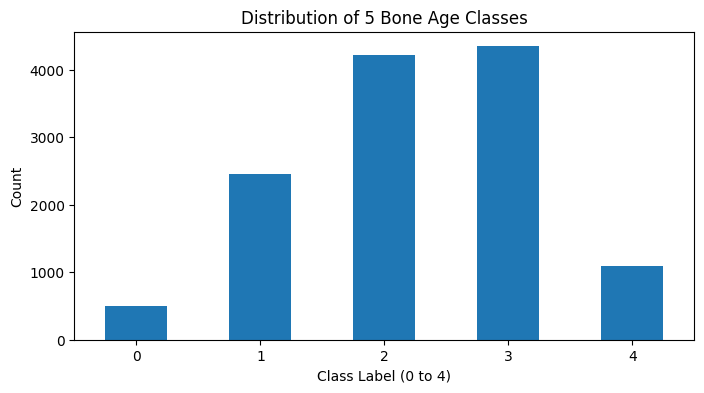

✓ Data cleaning and 5-class target generation complete.



In [2]:
# ============================================================================
# SECTION 2: DATA LOADING, CLEANING, AND 5-CLASS TARGET GENERATION
# ============================================================================

print("[STEP 1] Loading CSV metadata and checking image files...")
train_df = pd.read_csv(f'{DATA_PATH}/boneage-training-dataset.csv')

# --- 1. Robust Image Path Mapping and Validation ---
image_files = list(IMAGE_DIR.glob('*.png')) + list(IMAGE_DIR.glob('*.jpg')) + list(IMAGE_DIR.glob('*.jpeg'))
image_path_map = {int(img.stem): str(img) for img in image_files}
image_ids_with_files = set(image_path_map.keys())

# Filter the dataframe to only include IDs that have a corresponding image file
missing_files = (~train_df['id'].isin(image_ids_with_files)).sum()
if missing_files > 0:
    print(f"WARNING: {missing_files} records missing image files. Filtering...")
    train_df = train_df[train_df['id'].isin(image_ids_with_files)].reset_index(drop=True)
print(f"✓ {len(train_df)} valid records remaining for training.")

# --- 2. Feature Engineering ---
# Convert bone age from months to years
train_df['bone_age_years'] = train_df['boneage'] / 12.0
# Encode gender: True (Male) = 1, False (Female) = 0
train_df['sex_encoded'] = train_df['male'].astype(int) 

# --- 3. 5-Class Target Generation ---
# Class 0: 0 <= Age < 48 months (0.0 - 4.0y)
# Class 1: 48 <= Age < 96 months (4.0 - 8.0y)
# Class 2: 96 <= Age < 144 months (8.0 - 12.0y)
# Class 3: 144 <= Age < 180 months (12.0 - 15.0y)
# Class 4: Age >= 180 months (15.0+y)

bins = [0, 48, 96, 144, 180, train_df['boneage'].max() + 1]
labels = list(range(NUM_CLASSES)) 

train_df['bone_age_class'] = pd.cut(
    train_df['boneage'], 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
).astype(int)

print(f"\nClass Distribution ({NUM_CLASSES} Classes):")
print(train_df['bone_age_class'].value_counts().sort_index())

plt.figure(figsize=(8, 4))
train_df['bone_age_class'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Distribution of {NUM_CLASSES} Bone Age Classes')
plt.xlabel('Class Label (0 to 4)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

print("✓ Data cleaning and 5-class target generation complete.\n")

### STRATIFIED SPLIT OF DATA

In [3]:
# ============================================================================
# SECTION 3: STRATIFIED SPLIT AND PYTORCH SETUP
# ============================================================================

# --- 1. Stratified Train/Val/Test Split (70/15/15) ---
# Stratify based on the new 5-class target
print("[STEP 2] Performing stratified Train/Val/Test split (70/15/15)...")

# First split: Train+Val (85%) vs Test (15%)
train_val_df, test_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df['bone_age_class'],
    random_state=SEED
)

# Second split: Train (70%) vs Val (15%)
# (0.15/0.85 ≈ 0.17647)
train_df_split, val_df = train_test_split(
    train_val_df,
    test_size=0.17647,  
    stratify=train_val_df['bone_age_class'],
    random_state=SEED
)

print(f"Train set: {len(train_df_split)} samples (approx 70%)")
print(f"Validation set: {len(val_df)} samples (approx 15%)")
print(f"Test set: {len(test_df)} samples (approx 15%)")

# --- 2. Image Transformation Pipelines ---
MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]

# Training transformations (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Validation and Test transformations (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# --- 3. Custom PyTorch Dataset Class ---

class BoneAgeDataset(Dataset):
    """Custom Dataset using explicit image_path_map for reliability."""
    
    def __init__(self, dataframe, image_path_map, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.image_path_map = image_path_map
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_id = self.dataframe.loc[idx, 'id']
        img_path = Path(self.image_path_map[img_id]) 
        
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.loc[idx, 'bone_age_class']
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# --- 4. Create Datasets and DataLoaders ---

train_dataset = BoneAgeDataset(train_df_split, image_path_map, train_transforms)
val_dataset = BoneAgeDataset(val_df, image_path_map, val_test_transforms)
test_dataset = BoneAgeDataset(test_df, image_path_map, val_test_transforms)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2, pin_memory=True
)

print(f"✓ PyTorch DataLoaders created.")

[STEP 2] Performing stratified Train/Val/Test split (70/15/15)...
Train set: 8827 samples (approx 70%)
Validation set: 1892 samples (approx 15%)
Test set: 1892 samples (approx 15%)
✓ PyTorch DataLoaders created.


CLASSICAL ML PIPELINE - HOG FEATURES + XGBOOST CLASSIFIER

In [4]:
# HOG features
from skimage.feature import hog
from skimage import color

# XGBoost classifier
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not installed. Install with: !pip install xgboost")
    from xgboost import XGBClassifier

# Metrics (safe even if imported earlier)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    cohen_kappa_score
)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


In [5]:
import numpy as np
from tqdm import tqdm
from PIL import Image  # in case not imported above

def extract_hog_features(img_path, img_size=(128, 128)):
    """
    Load image, resize, convert to grayscale, compute HOG features.
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize(img_size)
    img_np = np.array(img)

    # Convert to grayscale for HOG
    gray = color.rgb2gray(img_np)

    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features


def build_hog_dataset(df, image_path_map):
    """
    Given df with 'id' and 'bone_age_class',
    create X (HOG features) and y (labels).
    """
    X = []
    y = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc='HOG features'):
        img_id = row['id']
        img_path = image_path_map[img_id]
        features = extract_hog_features(img_path)
        X.append(features)
        y.append(row['bone_age_class'])

    X = np.array(X)
    y = np.array(y)
    return X, y


In [6]:
print("Building HOG feature datasets (this may take some time)...")

X_train_hog, y_train_hog = build_hog_dataset(train_df_split, image_path_map)
X_val_hog,   y_val_hog   = build_hog_dataset(val_df,         image_path_map)
X_test_hog,  y_test_hog  = build_hog_dataset(test_df,        image_path_map)

print("\nShapes:")
print("  X_train_hog:", X_train_hog.shape, " y_train_hog:", y_train_hog.shape)
print("  X_val_hog:  ", X_val_hog.shape,   " y_val_hog:  ", y_val_hog.shape)
print("  X_test_hog: ", X_test_hog.shape,  " y_test_hog: ", y_test_hog.shape)


Building HOG feature datasets (this may take some time)...


HOG features: 100%|██████████| 1892/1892 [01:52<00:00, 16.74it/s]



Shapes:
  X_train_hog: (8827, 8100)  y_train_hog: (8827,)
  X_val_hog:   (1892, 8100)  y_val_hog:   (1892,)
  X_test_hog:  (1892, 8100)  y_test_hog:  (1892,)


In [11]:
# --- Faster XGBoost training on HOG features ---
print("Training XGBoost on HOG features (reduced depth & n_estimators)...")

try:
    # Try GPU-accelerated XGBoost first
    xgb_hog = XGBClassifier(
        objective='multi:softprob',
        num_class=NUM_CLASSES,
        learning_rate=0.07,
        max_depth=4,          # shallower trees -> faster
        n_estimators=80,      # fewer trees -> faster
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        n_jobs=-1,
        tree_method='gpu_hist',      # use GPU if supported
        predictor='gpu_predictor',
        gpu_id=0
    )
    print("[INFO] Using GPU XGBoost (tree_method='gpu_hist').")
except TypeError:
    # Fallback to CPU version if GPU params not supported
    xgb_hog = XGBClassifier(
        objective='multi:softprob',
        num_class=NUM_CLASSES,
        learning_rate=0.07,
        max_depth=4,
        n_estimators=80,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        n_jobs=-1,
        tree_method='hist'
    )
    print("[INFO] Falling back to CPU XGBoost (tree_method='hist').")

xgb_hog.fit(
    X_train_hog,            # <-- same HOG features, no resizing changes
    y_train_hog,
    eval_set=[(X_val_hog, y_val_hog)],
    eval_metric='mlogloss',
    verbose=False,
    early_stopping_rounds=20    # will stop early if no improvement
)

print("✅ XGBoost training completed.")


Training XGBoost on HOG features (reduced depth & n_estimators)...
[INFO] Using GPU XGBoost (tree_method='gpu_hist').
✅ XGBoost training completed.


In [12]:
# ---------- Validation performance ----------
val_proba = xgb_hog.predict_proba(X_val_hog)
val_preds = np.argmax(val_proba, axis=1)

val_acc = accuracy_score(y_val_hog, val_preds)
val_f1  = f1_score(y_val_hog, val_preds, average='weighted')
val_qwk = quadratic_weighted_kappa(y_val_hog, val_preds)
val_cm  = confusion_matrix(y_val_hog, val_preds)

print("=== HOG + XGBoost (Validation) ===")
print(f"Accuracy : {val_acc:.4f}")
print(f"F1-score : {val_f1:.4f}")
print(f"QWK      : {val_qwk:.4f}")
print("Confusion Matrix (Val):\n", val_cm)

# ---------- Test performance ----------
test_proba = xgb_hog.predict_proba(X_test_hog)
test_preds = np.argmax(test_proba, axis=1)

test_acc = accuracy_score(y_test_hog, test_preds)
test_f1  = f1_score(y_test_hog, test_preds, average='weighted')
test_qwk = quadratic_weighted_kappa(y_test_hog, test_preds)
test_cm  = confusion_matrix(y_test_hog, test_preds)

print("\n=== HOG + XGBoost (Test) ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"F1-score : {test_f1:.4f}")
print(f"QWK      : {test_qwk:.4f}")
print("Confusion Matrix (Test):\n", test_cm)

print("\nClassification Report (HOG + XGBoost):")
print(classification_report(y_test_hog, test_preds))


=== HOG + XGBoost (Validation) ===
Accuracy : 0.4593
F1-score : 0.4280
QWK      : 0.4630
Confusion Matrix (Val):
 [[ 13  36  12  13   0]
 [  6  98 211  53   0]
 [  2  51 327 252   0]
 [  2  17 203 428   3]
 [  0   3  38 121   3]]

=== HOG + XGBoost (Test) ===
Accuracy : 0.4762
F1-score : 0.4451
QWK      : 0.5016
Confusion Matrix (Test):
 [[ 13  43  10   9   0]
 [  3 111 207  47   0]
 [  2  39 341 250   0]
 [  1  16 202 433   0]
 [  0   3  32 127   3]]

Classification Report (HOG + XGBoost):
              precision    recall  f1-score   support

           0       0.68      0.17      0.28        75
           1       0.52      0.30      0.38       368
           2       0.43      0.54      0.48       632
           3       0.50      0.66      0.57       652
           4       1.00      0.02      0.04       165

    accuracy                           0.48      1892
   macro avg       0.63      0.34      0.35      1892
weighted avg       0.53      0.48      0.45      1892



#### MODEL ARCHITECTURE AND TRAINING

In [41]:
# ============================================================================
# SECTION 4: MODEL ARCHITECTURE, QWK, AND TRAINING BLOCK (30 EPOCHS)
# ============================================================================

NUM_EPOCHS=30
# --- 1. QWK Implementation ---
def quadratic_weighted_kappa(y_true, y_pred):
    """Calculates Quadratic Weighted Kappa (QWK) for ordinal classification."""
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# --- 2. Model Architecture ---
class BoneAgeClassifier(nn.Module):
    """Bone Age Classifier using ResNet50 (Transfer Learning) with 5-class output."""
    
    # Global variables NUM_CLASSES, RESNET_WEIGHTS_PATH, and device are assumed to be defined
    def __init__(self, num_classes=NUM_CLASSES, resnet_weights_path=None):
        super(BoneAgeClassifier, self).__init__()
        
        # Load ResNet50 base architecture
        self.backbone = models.resnet50(pretrained=False)
        
        # Load pre-trained weights from local file (FIXED PATH)
        if resnet_weights_path and Path(resnet_weights_path).exists():
            print(f"Loading ResNet50 weights from: {resnet_weights_path}")
            # NOTE: We use weights_only=False to prevent UnpicklingError from previously saved checkpoints
            state_dict = torch.load(resnet_weights_path, map_location=device, weights_only=False) 
            self.backbone.load_state_dict(state_dict)
            print("✓ ResNet50 weights loaded successfully!")
        else:
            print("⚠ Warning: ResNet weights not found. Using random initialization.")
        
        # Replace the final fully connected layer for 5-class classification
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Initialize model
model = BoneAgeClassifier(num_classes=NUM_CLASSES, resnet_weights_path=RESNET_WEIGHTS_PATH)
model = model.to(device)

print(f"\nModel architecture loaded to {device}.")

# --- 3. Training Loop (30 EPOCHS) ---

# Global variables NUM_EPOCHS (30), LEARNING_RATE, WEIGHT_DECAY, and MODEL_PATH are assumed defined

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_qwk': []}
best_qwk = -1.0
best_epoch = 0

print("\n" + "="*60)
print("STARTING TRAINING (30 EPOCHS)")
print("="*60)

for epoch in range(NUM_EPOCHS): # NUM_EPOCHS = 30
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # ========== TRAINING PHASE ==========
    model.train()
    train_loss = 0.0
    train_total = 0
    
    train_bar = tqdm(train_loader, desc='Training')
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        train_total += images.size(0)
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_train_loss = train_loss / train_total
    
    # ========== VALIDATION PHASE ==========
    model.eval()
    val_loss = 0.0
    val_total = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc='Validation')
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            val_total += images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
    epoch_val_loss = val_loss / val_total
    epoch_val_acc = accuracy_score(all_val_labels, all_val_preds)
    epoch_val_qwk = quadratic_weighted_kappa(all_val_labels, all_val_preds)
    
    # Update history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    history['val_qwk'].append(epoch_val_qwk)
    
    # Print epoch summary
    print(f"\nTrain Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc*100:.2f}% | Val QWK: {epoch_val_qwk:.4f}")
    
    scheduler.step(epoch_val_qwk)
    
    # Save best model based on QWK (Kaggle Persistence)
    if epoch_val_qwk > best_qwk:
        best_qwk = epoch_val_qwk
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_qwk': best_qwk,
            'history': history
        }, MODEL_PATH)
        print(f"✓ Best model saved to {MODEL_PATH}! (QWK: {best_qwk:.4f})")

print("\n" + "="*60)
print(f"TRAINING COMPLETED!")
print(f"Best QWK: {best_qwk:.4f} at epoch {best_epoch}")
print("="*60)

Loading ResNet50 weights from: /kaggle/input/resnet50-pretrained-wieghts/resnet50-11ad3fa6.pth
✓ ResNet50 weights loaded successfully!

Model architecture loaded to cuda.

STARTING TRAINING (30 EPOCHS)

Epoch 1/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.45it/s]



Train Loss: 0.9498
Val Loss: 0.6556 | Val Acc: 69.34% | Val QWK: 0.8344
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8344)

Epoch 2/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.6740
Val Loss: 0.5762 | Val Acc: 73.84% | Val QWK: 0.8612
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8612)

Epoch 3/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.6354
Val Loss: 0.6406 | Val Acc: 72.73% | Val QWK: 0.8512

Epoch 4/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.5918
Val Loss: 0.5313 | Val Acc: 76.32% | Val QWK: 0.8768
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8768)

Epoch 5/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.5602
Val Loss: 0.5646 | Val Acc: 75.26% | Val QWK: 0.8826
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8826)

Epoch 6/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Train Loss: 0.5447
Val Loss: 0.5760 | Val Acc: 74.05% | Val QWK: 0.8561

Epoch 7/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Train Loss: 0.5212
Val Loss: 0.5084 | Val Acc: 78.01% | Val QWK: 0.8810

Epoch 8/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Train Loss: 0.5132
Val Loss: 0.4882 | Val Acc: 80.23% | Val QWK: 0.8920
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8920)

Epoch 9/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.46it/s]



Train Loss: 0.4943
Val Loss: 0.4819 | Val Acc: 79.18% | Val QWK: 0.8958
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8958)

Epoch 10/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Train Loss: 0.4803
Val Loss: 0.4808 | Val Acc: 80.07% | Val QWK: 0.8978
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.8978)

Epoch 11/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Train Loss: 0.4719
Val Loss: 0.5014 | Val Acc: 79.49% | Val QWK: 0.8966

Epoch 12/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.4674
Val Loss: 0.4623 | Val Acc: 80.39% | Val QWK: 0.8965

Epoch 13/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.46it/s]



Train Loss: 0.4520
Val Loss: 0.4877 | Val Acc: 79.28% | Val QWK: 0.8879

Epoch 14/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.46it/s]



Train Loss: 0.4364
Val Loss: 0.4919 | Val Acc: 80.07% | Val QWK: 0.8934

Epoch 15/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.3963
Val Loss: 0.4919 | Val Acc: 81.08% | Val QWK: 0.9008
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.9008)

Epoch 16/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.46it/s]



Train Loss: 0.3760
Val Loss: 0.5058 | Val Acc: 79.86% | Val QWK: 0.8940

Epoch 17/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.46it/s]



Train Loss: 0.3584
Val Loss: 0.4719 | Val Acc: 80.44% | Val QWK: 0.9002

Epoch 18/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.44it/s]



Train Loss: 0.3489
Val Loss: 0.5001 | Val Acc: 81.29% | Val QWK: 0.9036
✓ Best model saved to best_classifier_model_5class.pth! (QWK: 0.9036)

Epoch 19/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.46it/s]



Train Loss: 0.3390
Val Loss: 0.5775 | Val Acc: 77.59% | Val QWK: 0.8888

Epoch 20/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.3384
Val Loss: 0.5266 | Val Acc: 79.92% | Val QWK: 0.8980

Epoch 21/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.2642
Val Loss: 0.5739 | Val Acc: 79.55% | Val QWK: 0.8887

Epoch 24/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.2488
Val Loss: 0.5789 | Val Acc: 80.18% | Val QWK: 0.8973

Epoch 25/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]



Train Loss: 0.2475
Val Loss: 0.6080 | Val Acc: 79.65% | Val QWK: 0.8939

Epoch 26/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.47it/s]



Train Loss: 0.2369
Val Loss: 0.6195 | Val Acc: 78.86% | Val QWK: 0.8893

Epoch 27/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.49it/s]



Train Loss: 0.2238
Val Loss: 0.6270 | Val Acc: 79.65% | Val QWK: 0.8935

Epoch 28/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:41<00:00,  1.45it/s]



Train Loss: 0.2200
Val Loss: 0.6211 | Val Acc: 79.18% | Val QWK: 0.8914

Epoch 29/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.49it/s]



Train Loss: 0.2098
Val Loss: 0.6703 | Val Acc: 78.70% | Val QWK: 0.8875

Epoch 30/30
----------------------------------------


Validation: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


Train Loss: 0.2013
Val Loss: 0.6701 | Val Acc: 80.50% | Val QWK: 0.8985

TRAINING COMPLETED!
Best QWK: 0.9036 at epoch 18


## MODEL EVALUATION


INFERENCE BLOCK - Loading Saved Model (Best QWK: 0.9036)
⚠ Warning: ResNet weights not found. Using random initialization.
✓ Model loaded successfully from best_classifier_model_5class.pth

EVALUATING ON TEST SET


Testing: 100%|██████████| 60/60 [00:47<00:00,  1.27it/s]



FINAL TEST SET RESULTS
Accuracy: 78.17%
F1-Score (Weighted): 0.7815
Quadratic Weighted Kappa (QWK): 0.8888

Classification Report:
              precision    recall  f1-score   support

    0 (0-4y)       0.78      0.75      0.76        75
    1 (4-8y)       0.74      0.84      0.79       368
   2 (8-12y)       0.75      0.73      0.74       632
  3 (12-15y)       0.82      0.79      0.81       652
    4 (15+y)       0.84      0.82      0.83       165

    accuracy                           0.78      1892
   macro avg       0.79      0.79      0.79      1892
weighted avg       0.78      0.78      0.78      1892



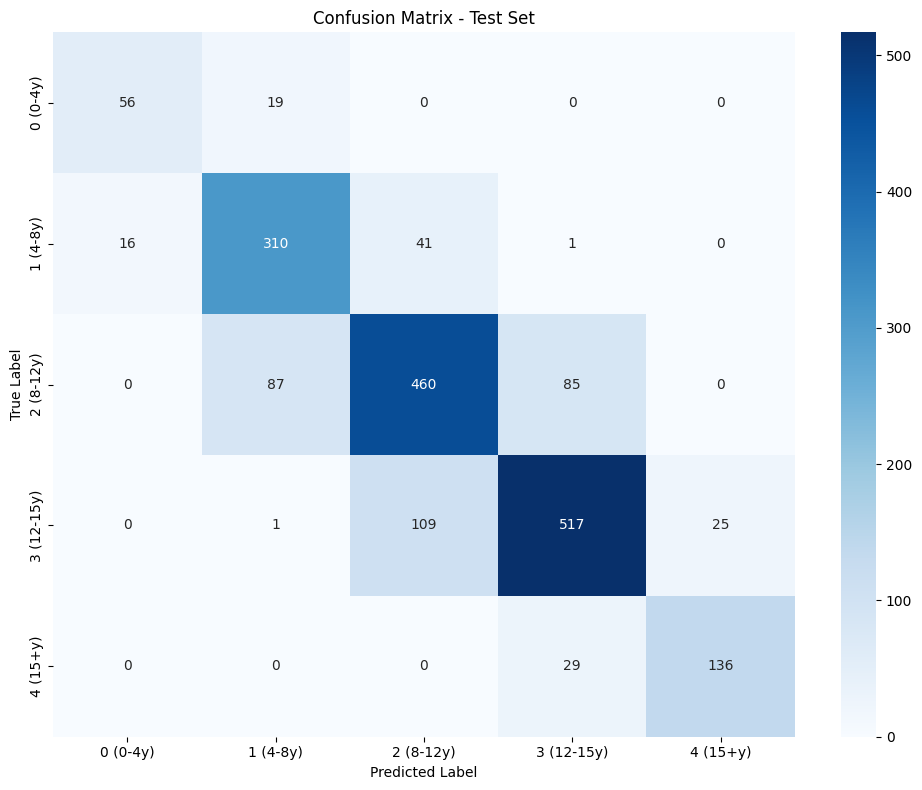


GENDER-WISE BIAS ANALYSIS

Sample counts: Male: 1027, Female: 865

Performance comparison:
      Metric    Male  Female  Difference (Male - Female)
Accuracy (%) 78.6758 77.5723                      1.1035
    F1-Score  0.7900  0.7756                      0.0144
         QWK  0.8925  0.8732                      0.0194

✓ Project evaluation complete!


In [42]:
# ============================================================================
# SECTION 5: INFERENCE, EVALUATION, AND BIAS ANALYSIS
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
from tqdm import tqdm

# Global variables (MODEL_PATH, NUM_CLASSES, device, test_loader, test_df) are assumed defined

# --- 1. Model Loading (Inference Block - Bypassing Unpickling Error) ---
print("\n" + "="*60)
print("INFERENCE BLOCK - Loading Saved Model (Best QWK: 0.9036)")
print("="*60)

# Re-initialize model architecture
model_inference = BoneAgeClassifier(num_classes=NUM_CLASSES, resnet_weights_path=None) 
model_inference = model_inference.to(device)

try:
    # Load saved checkpoint using weights_only=False fix
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    model_inference.load_state_dict(checkpoint['model_state_dict'])
    model_inference.eval()

    print(f"✓ Model loaded successfully from {MODEL_PATH}")
    
except Exception as e:
    print(f"✗ FATAL ERROR: Could not load saved model. Please ensure MODEL_PATH is correct. Error: {e}")
    # If loading fails, you cannot proceed with evaluation
    raise e


# --- 2. Evaluation on Test Set ---
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

all_test_preds = []
all_test_labels = []

model_inference.eval()
with torch.no_grad():
    test_bar = tqdm(test_loader, desc='Testing')
    for images, labels in test_bar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model_inference(images)
        _, predicted = torch.max(outputs, 1)
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)

# Calculate final metrics
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0) 
test_qwk = cohen_kappa_score(all_test_labels, all_test_preds, weights='quadratic')

print("\n" + "="*60)
print("FINAL TEST SET RESULTS")
print("="*60)
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"F1-Score (Weighted): {test_f1:.4f}")
print(f"Quadratic Weighted Kappa (QWK): {test_qwk:.4f}")
print("="*60)

CLASS_NAMES = ['0 (0-4y)', '1 (4-8y)', '2 (8-12y)', '3 (12-15y)', '4 (15+y)']

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=CLASS_NAMES, zero_division=0))

# --- 3. Confusion Matrix Visualization ---
cm = confusion_matrix(all_test_labels, all_test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- 4. Gender-wise Bias Analysis ---
print("\n" + "="*60)
print("GENDER-WISE BIAS ANALYSIS")
print("="*60)

# Add predictions to test dataframe (test_df must be available from SECTION 3)
test_df_eval = test_df.copy().reset_index(drop=True)
test_df_eval['predicted_class'] = all_test_preds

# Define metric calculation function
def calculate_gender_metrics(df):
    labels = df['bone_age_class'].values
    preds = df['predicted_class'].values
    accuracy = accuracy_score(labels, preds)
    qwk = cohen_kappa_score(labels, preds, weights='quadratic')
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return accuracy, f1, qwk

# Separate by gender (True=Male, False=Female)
male_df = test_df_eval[test_df_eval['male'] == True] 
female_df = test_df_eval[test_df_eval['male'] == False]

male_acc, male_f1, male_qwk = calculate_gender_metrics(male_df)
female_acc, female_f1, female_qwk = calculate_gender_metrics(female_df)

# Create comparison table
bias_analysis = pd.DataFrame({
    'Metric': ['Accuracy (%)', 'F1-Score', 'QWK'],
    'Male': [male_acc*100, male_f1, male_qwk],
    'Female': [female_acc*100, female_f1, female_qwk],
    'Difference (Male - Female)': [
        (male_acc - female_acc)*100,
        male_f1 - female_f1,
        male_qwk - female_qwk
    ]
})

print(f"\nSample counts: Male: {len(male_df)}, Female: {len(female_df)}")
print(f"\nPerformance comparison:")
print(bias_analysis.to_string(index=False, float_format='%.4f'))

print("\n✓ Project evaluation complete!")